In [1]:
# https://www.mdpi.com/2076-3417/12/19/10077

In [2]:
import os
# !pwd

from pathlib import Path

dir_path = Path(r"/Users/rabinatwayana/Rabina/CDE II/Wildfire Project/SAR-Burnt-Area-Mapping/")

if dir_path.exists():
    os.chdir(dir_path)
else:
    print("Directory does not exist! Please check the path.")

In [3]:
import geopandas as gpd
import rasterio
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,\
                            precision_score,recall_score,f1_score,roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=UserWarning)
import joblib
import os
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from utils import evaluate_model, run_model, create_fish_net, prepare_training_sample



In [4]:
metrics_combined=[]
hyperparameter_tuning=False
tile_size=100
gt_image_path="MachineLearning/input/ground_truth/02_gt/gt_palisade.tif"


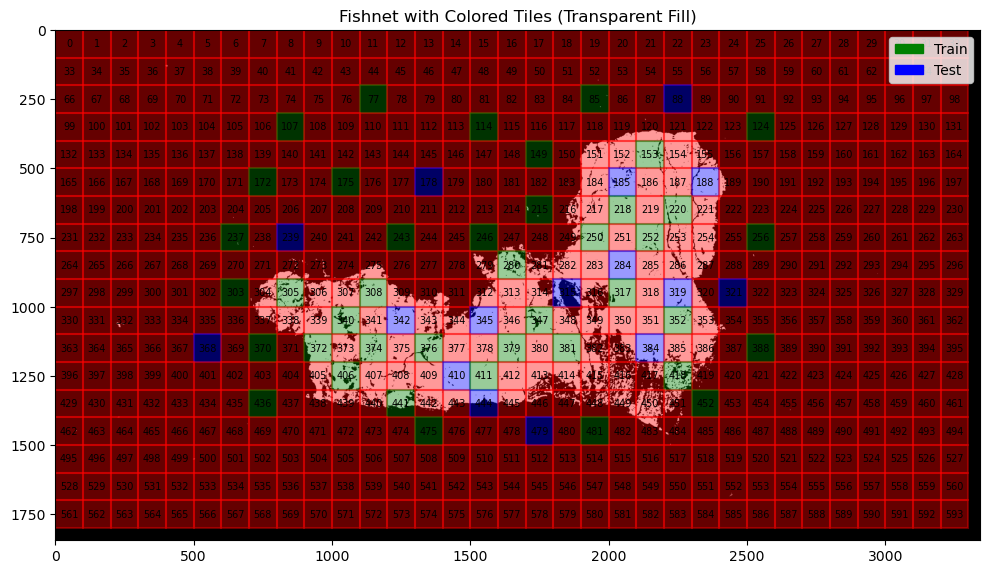

fishnet tile generation done


In [5]:
# tiles=create_fish_net("MachineLearning/output/feature_image/palisades_sar_asc.tif", gt_image_path, tile_size=256,plot_fig=True)
# train_ids=None, val_ids=None, test_ids=None
# _1
# train_ids = [305,308,375, 372,411,414,441,438,318,250,219,221,152,280,418,475,481,124,256,452,237,243,215,114,107,175,370,85,435]
# test_ids = [154, 351,345,340, 184, 478,355,178,368,88,172,439]

# _2
# train_ids = [305,308,375, 372,411,414,441,438,318,250,219,221,152,280,418,475,481,124,256,452,237,243,215,114,107,175,370,85,435,303,347,377,190]
# test_ids = [154, 351,345,340, 184, 478,355,178,368,88,172,439]
# tiles=create_fish_net("MachineLearning/input/sar/02_clip/S1A_asc_32611_avg_clip.tif", gt_image_path, tile_size=tile_size,plot_fig=True,train_ids=train_ids,test_ids=test_ids)

train_ids = [218,149,172,153,246,352,305,308, 372,411,381,441,406,317,250,252,220,280,418,475,481,124,256,452,237,243,215,114,107,175,370,85,436,303,347,376,388,374,379,340,77]
test_ids = [284,185, 319,345,342, 479,321,178,368,88,239,384,410,188,315,444]
tiles=create_fish_net("MachineLearning/input/sar/02_clip/S1A_asc_32611_avg_clip.tif", gt_image_path, tile_size=tile_size,plot_fig=True,train_ids=train_ids,test_ids=test_ids)

### Model best hyperparameter selection

In [6]:

if hyperparameter_tuning:
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier

    # Define parameter grid
    rf_params = {
        'n_estimators': [50, 100, 150],  # Number of trees
        'max_depth': [10, 20,30],  # Depth of trees
        'min_samples_split': [10, 20, 40],  # Minimum samples to split
        'max_features': [2, 4, 'sqrt', 'log2'],  # Features to consider at each split
        'class_weight': ['balanced_subsample', 'balanced'],  # Handle class imbalance
        'max_samples': [0.3,0.5, 0.7],  # Fraction of samples to train each tree on
    }

    # Initialize GridSearchCV with parameter grid
    # grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, cv=3, verbose=2, n_jobs=-1)
    grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params, cv=3, verbose=2, n_jobs=-1)

    feature_image_path="MachineLearning/output/feature_image/palisades_sar_avg_asc_desc.tif"
    # gt_image_path="MachineLearning/gt/palisades_label_0_17.tif"

    tiles=create_fish_net(feature_image_path, gt_image_path, tile_size=tile_size,plot_fig=False)

    train_ids = [154, 351,345,340, 184, 478,355,178,368,88,172,439,303,219,375,435]
    test_ids=[]

    # X_train, X_test, y_train, y_test = prepare_training_sample(sample_feature_path, feature_column_names, class_column_name,drop_columns, corr_mat_dir, model_name, extended_file_name)
    X_train, y_train, X_test, y_test = prepare_training_sample(tiles, train_ids,test_ids)
    print(X_train.shape,y_train.shape,"hbfhsdvchsdvch")

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Print the best parameters found
    print(grid_search.best_params_)


In [7]:

# RF_Model_1=RandomForestClassifier(n_estimators= 300, min_samples_split= 40, max_features= 2,max_depth= 10,bootstrap=True)
# RF_Model_2=RandomForestClassifier(n_estimators= 100,max_samples=0.3, class_weight="balanced_subsample",min_samples_split= 40, max_features= 2,max_depth= 10,bootstrap=True)
# RF_Model_3=RandomForestClassifier(n_estimators= 100,max_samples=0.5, class_weight="balanced_subsample",bootstrap=True,n_jobs=-1)
# RF_Model_4=RandomForestClassifier(n_estimators= 100,max_samples=0.5, class_weight="balanced",bootstrap=True,n_jobs=-1) 

#Through model selection
# {'n_estimators': 150, 'min_samples_split': 20, 'max_samples': 0.3, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}
# RF_Model=RandomForestClassifier(
#     n_estimators= 150, 
#     class_weight="balanced",
#     max_samples= 0.3, 
#     min_samples_split= 20, 
#     max_features= 'sqrt',
#     max_depth=20,
#     bootstrap=True)

# 100,20,0.3
# {'n_estimators': 150, 'min_samples_split': 10, 'max_samples': 0.7, 'max_features': 4, 'max_depth': 10, 'class_weight': 'balanced_subsample'}
RF_Model=RandomForestClassifier(
    n_estimators= 150, 
    class_weight="balanced_subsample",
    max_samples= 0.7, 
    min_samples_split= 10, 
    max_features= 4,
    max_depth=10,
    bootstrap=True)
# models={
#     "RandomForest": RF_Model,
# }
model_name="RandomForest"
model=RF_Model

In [8]:
scheme_1 =False
scheme_2 =False
scheme_3 =False
scheme_4 =True
# scheme_5 =True
# scheme_6 =False
# scheme_7 =False

In [9]:
# drop_columns=['x','y','class']
# class_column_name='class'
# drop_columns=['geometry','Dnbr1','id','class']
# corr_mat_dir="MachineLearning/output/correlation/"



In [10]:
output_model_dir="MachineLearning/output/model/"
output_feat_imp_dir="MachineLearning/output/feature_importance/"
feature_column_names=["RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI"]
feature_column_names_with_glcm=["RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI",'p1','p2','p3']
# gt_image_path="MachineLearning/input/ground_truth/02_gt/gt_palisade.tif"

***************RandomForest*********************
fishnet tile generation done
(410000, 8) (410000,) hbfhsdvchsdvch
Model performance for Training set
Model performance
- Accuracy: 0.8583975609756097
- F1 Score: 0.8582704573570952
- Precision Score: 0.8583185242786316
- Recall Score: 0.8583975609756097
- Roc Auc Score: 0.8567274473182206
--------------
Model performance for Test set
Model performance
- Accuracy: 0.84104375
- F1 Score: 0.8412365861488462
- Precision Score: 0.844369533568157
- Recall Score: 0.84104375
- Roc Auc Score: 0.8432177394695747
----------------------------------------
Model saved successfully!


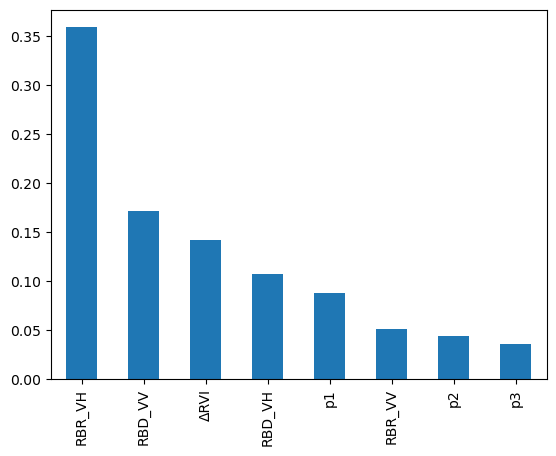

In [11]:
if scheme_1:
    file_name="palisades_sar_avg_asc"
    metrics_1=run_model(
            feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
            #   sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
            model_name=model_name,
              model=model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=tile_size
               )
    metrics_combined.append(metrics_1)

if scheme_2:
    #1 Asc glcm
    file_name="palisades_sar_avg_desc"
    metrics_2=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
              # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
             
              model_name=model_name,
              model=model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=tile_size
               )
    metrics_combined.append(metrics_2)


if scheme_3:
    #1 Asc avg
    file_name="palisades_sar_avg_asc_desc"
    metrics_3=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
              
              # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
              model_name=model_name,
              model=model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=tile_size
               )
    metrics_combined.append(metrics_3)
    
    
    
if scheme_4:
    #1 Asc avg + glcm
    file_name="palisades_sar_avg_asc_desc_glcm"
    metrics_4=run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
              gt_image_path=gt_image_path,
              
              # sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
              feature_column_names=feature_column_names_with_glcm, 
            #   drop_columns=drop_columns, 
            #   class_column_name=class_column_name ,
              model_name=model_name,
              model=model,
              output_model_dir=output_model_dir,
               output_feat_imp_dir=output_feat_imp_dir,
            #    corr_mat_dir=corr_mat_dir,
               extended_file_name=f"_{file_name}",
               train_ids=train_ids, 
               test_ids=test_ids, 
               tile_size=tile_size
               )
    metrics_combined.append(metrics_4)
    

# if scheme_5:
#     #avg asc + desc
#     file_name="palisades_sar_avgasc_desc"
#     run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif",
#               gt_image_path=gt_image_path,
               
#               sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
#               feature_column_names=feature_column_names, 
#               drop_columns=drop_columns, 
#               class_column_name=class_column_name ,
#               models=models,
#               output_model_dir=output_model_dir,
#                output_feat_imp_dir=output_feat_imp_dir,
#                corr_mat_dir=corr_mat_dir,
#                extended_file_name=f"_{file_name}")
   
    
# if scheme_6:
#     #avg asc + desc + glcm
#     file_name="palisades_sar_avgasc_desc_glcm"
#     run_model(feature_image_path=f"MachineLearning/output/feature_image/{file_name}.tif", 
#               gt_image_path=gt_image_path,
              
#               sample_feature_path=f"MachineLearning/output/sample_feature/{file_name}.csv", 
#               feature_column_names=feature_column_names_with_glcm, 
#               drop_columns=drop_columns, 
#               class_column_name=class_column_name,
#               models=models,
#               output_model_dir=output_model_dir,
#                output_feat_imp_dir=output_feat_imp_dir,
#                corr_mat_dir=corr_mat_dir,
#                extended_file_name=f"_{file_name}")
    
   

In [12]:

print(metrics_combined)
# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_combined)

# Save to CSV
df_metrics.to_csv('MachineLearning/output/metrics_comparison_train_test.csv', index=False)

print("CSV file created successfully!")

[{'acc_train': 0.8584, 'f1_train': 0.8583, 'precision_train': 0.8583, 'recall_train': 0.8584, 'roc_auc_train': np.float64(0.8567), 'acc_test': 0.841, 'f1_test': 0.8412, 'precision_test': 0.8444, 'recall_test': 0.841, 'roc_auc_test': np.float64(0.8432)}]
CSV file created successfully!
